***LINE-1 Implementation***

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


class BatchAliasSampler:
    def __init__(self, probabilities):
        self.n = len(probabilities)
        self.alias = np.zeros((self.n, 2), dtype=np.int)
        self.prob = np.zeros(self.n)

        scaled_probabilities = probabilities * self.n

        small, large = [], []
        for i, prob in enumerate(scaled_probabilities):
            if prob < 1.0:
                small.append(i)
            else:
                large.append(i)

        while small and large:
            small_idx, large_idx = small.pop(), large.pop()
            self.prob[small_idx] = scaled_probabilities[small_idx]
            self.alias[small_idx] = (large_idx, scaled_probabilities[small_idx])
            scaled_probabilities[large_idx] -= (1.0 - scaled_probabilities[small_idx])
            if scaled_probabilities[large_idx] < 1.0:
                small.append(large_idx)
            else:
                large.append(large_idx)

    def sample(self, size):
        indices = np.random.randint(0, self.n, size=size)
        coin_tosses = np.random.rand(size) < self.prob[indices]

        # Use np.where to conditionally select values from the alias array
        return np.where(coin_tosses, indices, self.alias[indices, 0])


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def negative_sampling(graph, target_node, num_samples):
    neighbors = set(graph.neighbors(target_node))
    degrees = dict(graph.degree())

    # Filter nodes not in neighbors
    candidate_nodes = [node for node in graph.nodes() if node not in neighbors]

    # Compute weights based on the degree of the node to the power of 3/4
    weights = np.array([(degrees[node] ** 0.75) for node in candidate_nodes])

    # Normalize weights
    weights /= np.sum(weights)

    # Sample negative nodes using the computed weights
    negative_nodes = np.random.choice(candidate_nodes, size=num_samples, replace=False, p=weights)

    return negative_nodes.tolist()


def initialize_embeddings(nodes, dimensions):
    return {node: np.random.rand(dimensions) for node in nodes}

def line1(graph, dimensions=128, num_samples=5, learning_rate0=0.025, epochs=100, edge_sampling_ratio=1):
    nodes = list(graph.nodes())
    edges = list(graph.edges())
    num_edge_samples = int(len(edges) * edge_sampling_ratio)

    # Calculate edge sampling probabilities based on edge weights
    edge_weights = np.array([graph[u][v].get('weight', 1.0) for u, v in edges])
    edge_probs = edge_weights / np.sum(edge_weights)

    # Use alias method for edge sampling
    embeddings = initialize_embeddings(nodes, dimensions)

    # nodes = list(graph.nodes())

    # # Calculate edge sampling probabilities based on edge weights
    # edge_weights = np.array([graph[u][v].get('weight', 1.0) for u, v in graph.edges()])
    # edge_probs = edge_weights / np.sum(edge_weights)

    # # Sample edges based on probabilities
    # sampled_edges = np.random.choice(graph.edges(), size=int(len(graph.edges()) * edge_sampling_ratio), p=edge_probs, replace=False)

    # embeddings = initialize_embeddings(nodes, dimensions)
    eps = 0.00001
    global_losses = []

    for epoch in range(epochs):
        learning_rate = learning_rate0*(1 - epoch/num_edge_samples)
        alias_sampler = BatchAliasSampler(edge_probs)
        sampled_edges = [(edges[i]) for i in alias_sampler.sample(num_edge_samples)]

        # print("sampled_edges = ", sampled_edges)

        global_loss = 0
        # print("sampled_edges =",sampled_edges)
        for source_node, target_node in sampled_edges:
            # Positive sample
            target_embedding = embeddings[source_node]
            context_embedding = embeddings[target_node]

            positive_loss = -np.log(sigmoid(np.dot(target_embedding, context_embedding)) + eps)

            grad_positive = sigmoid(np.dot(target_embedding, context_embedding)) - 1
            embeddings[source_node] -= learning_rate * grad_positive * context_embedding
            embeddings[target_node] -= learning_rate * grad_positive * target_embedding

            # Negative samples
            negative_nodes = negative_sampling(graph, source_node, num_samples)
            # print("source_node =",source_node)
            # print("negative_nodes =",negative_nodes)
            for neg_node in negative_nodes:
                neg_embedding = embeddings[neg_node]
                negative_loss = -np.log(sigmoid(-np.dot(target_embedding, neg_embedding)) + eps)

                # Update embeddings
                grad_negative = sigmoid(np.dot(target_embedding, neg_embedding))
                embeddings[source_node] -= learning_rate * grad_negative * neg_embedding
                embeddings[neg_node] -= learning_rate * grad_negative * target_embedding

                global_loss += negative_loss

            # Accumulate losses
            global_loss += positive_loss

        # Average the global loss over the sampled edges
        global_loss /= len(sampled_edges)
        global_losses.append(global_loss)

        # Print or log the global loss for monitoring
        # print(f"Epoch {epoch + 1}/{epochs}, Global Loss: {global_loss}")

    return embeddings





***Testing the method :***

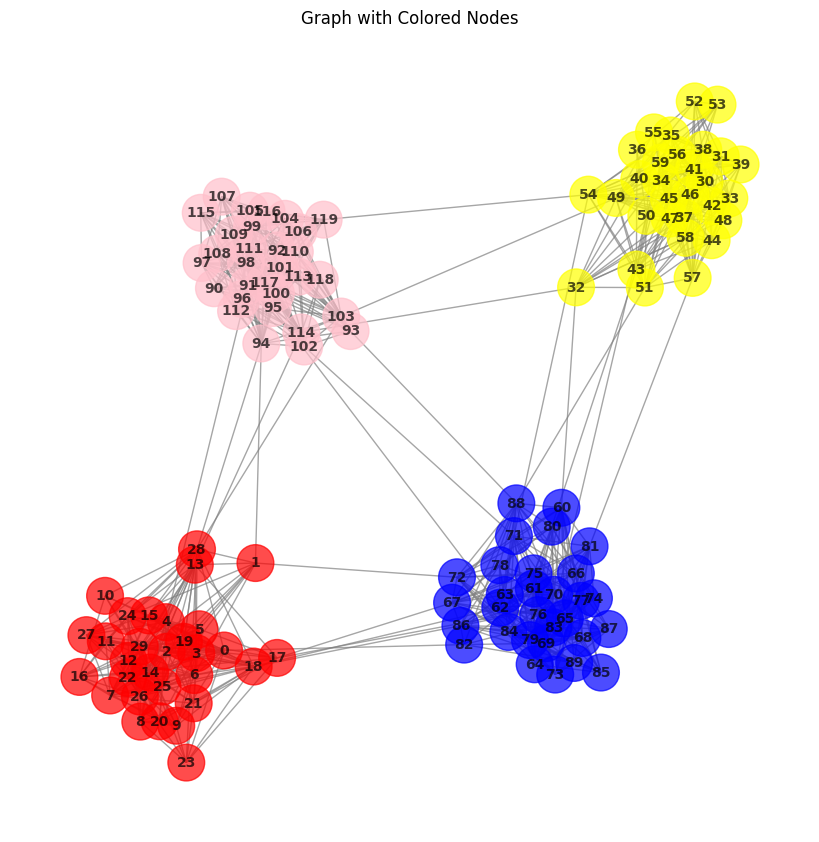

<ipython-input-1-ea812a756eb6>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.alias = np.zeros((self.n, 2), dtype=np.int)


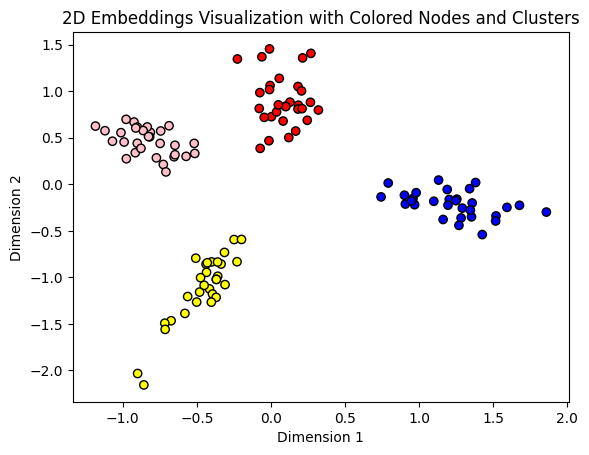

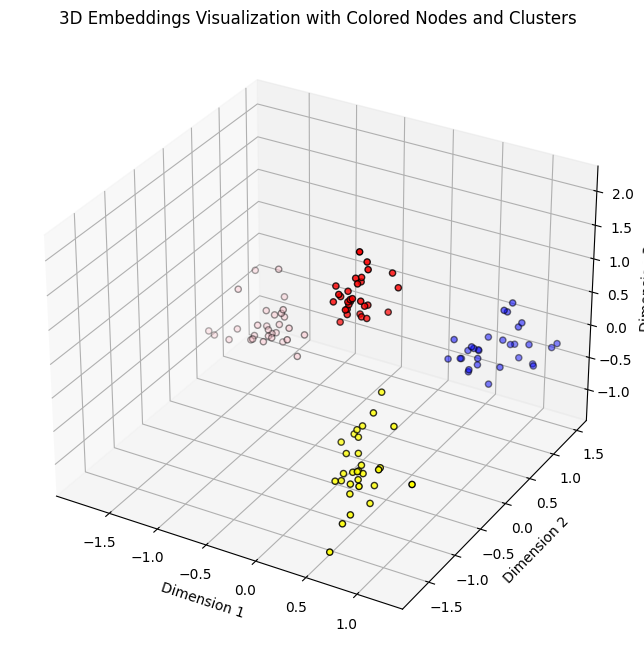

In [ ]:
def visualize_graph_with_colors(graph):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 8))

    node_colors = [graph.nodes[node]['color'] for node in graph.nodes()]
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color=node_colors,
            font_size=10, font_color="black", font_weight="bold", edge_color="gray", linewidths=1, alpha=0.7)

    plt.title("Graph with Colored Nodes")
    plt.show()

# Create a graph with clusters
def generate_clustered_graph():
    graph = nx.Graph()
    cluster_sizes = [30, 30, 30]
    node_count = sum(cluster_sizes)
    color_palette = ['red', 'yellow', 'blue', 'pink']
    edge_prob_same_color = 0.9  # Adjust the probability as needed
    edge_prob_diff_color = 0.1  # Adjust the probability as needed

    colors = []
    for cluster_index, cluster_size in enumerate(cluster_sizes):
        for i in range(cluster_size):
            node = sum(cluster_sizes[:cluster_index]) + i
            color = color_palette[cluster_index]
            graph.add_node(node, color=color)
            colors.append(color)

    for i in range(node_count):
        for j in range(i + 1, node_count):
            if np.random.rand() < 0.5 :
              if np.random.rand() < edge_prob_same_color:
                  # Connect nodes with the same color
                  if graph.nodes[i]['color'] == graph.nodes[j]['color']:
                      graph.add_edge(i, j, weight=np.random.rand())
              elif np.random.rand() < edge_prob_diff_color:
                  # Connect nodes with different colors
                  if graph.nodes[i]['color'] != graph.nodes[j]['color']:
                      graph.add_edge(i, j, weight=np.random.rand())

    nx.set_node_attributes(graph, dict(zip(graph.nodes(), colors)), 'color')

    return graph

# Example usage:
clustered_graph = generate_clustered_graph()

# Visualize the graph with clusters
visualize_graph_with_colors(clustered_graph)

# LINE-1 embeddings
embeddings = line1(clustered_graph, num_samples=5, dimensions=2, epochs=100, edge_sampling_ratio = 0.6)

# Plot the 2D embeddings
x = [coord[0] for coord in embeddings.values()]
y = [coord[1] for coord in embeddings.values()]

plt.scatter(x, y, marker='o', c=[clustered_graph.nodes[node]['color'] for node in clustered_graph.nodes()], edgecolors='black')

# # Annotate points with their node colors
# for node, (x_val, y_val) in embeddings.items():
#     plt.text(x_val + 0.01, y_val + 0.01, clustered_graph.nodes[node]['color'], fontsize=12, ha='center', va='center')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings Visualization with Colored Nodes and Clusters')

plt.show()


# LINE-1 embeddings with 3 dimensions
embeddings_3d = line1(clustered_graph, dimensions=3, epochs=100, edge_sampling_ratio=0.4)

# Extract x, y, and z coordinates from the 3D embeddings
x_3d = [coord[0] for coord in embeddings_3d.values()]
y_3d = [coord[1] for coord in embeddings_3d.values()]
z_3d = [coord[2] for coord in embeddings_3d.values()]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x_3d, y_3d, z_3d, c=[clustered_graph.nodes[node]['color'] for node in clustered_graph.nodes()], edgecolors='black', marker='o')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('3D Embeddings Visualization with Colored Nodes and Clusters')

plt.show()